In [10]:
import torch
import lightning as L
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import DDPMScheduler
from datasets import load_dataset
from torchvision import transforms
from diffusers import UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup

In [3]:
image_size = 32
train_batch_size = 32
T = 200
num_epochs = T + 1
learning_rate = 5e-4
lr_warmup_steps = 100

Repo card metadata block was not found. Setting CardData to empty.


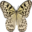

In [4]:
dataset = load_dataset(
    "huggan/smithsonian_butterflies_subset", 
    split="train", 
    cache_dir="./cache"
)

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

sample_image = dataset[0]["images"].unsqueeze(0)

Image.fromarray(((sample_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [5]:
train_dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=train_batch_size, 
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

In [6]:
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 32, 64, 64, 128, 128),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

num_params = sum(p.numel() for p in model.parameters())
print(f"The model has {num_params:,} trainable parameters")

The model has 7,126,275 trainable parameters


In [9]:
class DiffusionModel(L.LightningModule):
    def __init__(self, model, noise_scheduler):
        super().__init__()
        self.model = model
        self.noise_scheduler = noise_scheduler

    def training_step(self, batch, batch_idx):
        images = batch["images"]
        noise = torch.randn_like(images)
        steps = torch.randint(self.noise_scheduler.config.num_train_timesteps, (images.size(0),), device=self.device)
        noisy_images = self.noise_scheduler.add_noise(images, noise, steps)
        residual = self.model(noisy_images, steps).sample
        loss = torch.nn.functional.mse_loss(residual, noise)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4)
        scheduler =get_cosine_schedule_with_warmup(
            optimizer=optimizer,
            num_warmup_steps=lr_warmup_steps,
            num_training_steps=(len(train_dataloader) * num_epochs),
        )
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "step", "frequency": 1}}

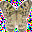

In [7]:
noise_scheduler = DDPMScheduler(num_train_timesteps=200)

noise = torch.randn(sample_image.shape)

timesteps = torch.LongTensor([10])

noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])